In [1]:
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping

In [2]:
data = yf.download(' aapl ',interval="1m")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)
data.reset_index(inplace=True)
data=pd.DataFrame(data["close"])

data

[*********************100%%**********************]  1 of 1 completed


,close
0,173.872803
1,173.660004
2,174.179993
3,174.339996
4,174.272903
...,...
1945,175.710007
1946,175.809998
1947,175.619995
1948,175.529999


In [3]:
train=data.loc[:len(data)-31,:]
test=data.loc[len(data)-30:,:]

In [4]:
data1=data.loc[len(data)-37:len(data)-31,:]
len(data1)

7

In [5]:
data1=pd.concat([data1,pd.DataFrame({"close":[0.0]*30})],ignore_index=True,axis=0)

In [6]:
train, test

(           close
 0     173.872803
 1     173.660004
 2     174.179993
 3     174.339996
 4     174.272903
 ...          ...
 1915  176.811096
 1916  176.619995
 1917  176.709396
 1918  176.729996
 1919  176.759995
 
 [1920 rows x 1 columns],
            close
 1920  176.699997
 1921  176.737000
 1922  176.380005
 1923  176.179993
 1924  176.110596
 1925  176.139999
 1926  176.070007
 1927  175.949997
 1928  175.861603
 1929  175.869995
 1930  175.945007
 1931  175.750000
 1932  175.630005
 1933  175.678406
 1934  175.649994
 1935  175.720001
 1936  175.654999
 1937  175.772705
 1938  175.740005
 1939  175.829300
 1940  175.940002
 1941  175.910004
 1942  176.029999
 1943  176.070801
 1944  175.895004
 1945  175.710007
 1946  175.809998
 1947  175.619995
 1948  175.529999
 1949  175.490005)

In [7]:

data1

,close
0,176.649994
1,176.729996
2,176.811096
3,176.619995
4,176.709396
5,176.729996
6,176.759995
7,0.000000
8,0.000000
9,0.000000


In [8]:
len(train),len(test)

(1920, 30)

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [10]:
device= 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [11]:
from copy import deepcopy as dc
def prepareforlstm(df,loookback):
    df=pd.DataFrame(df["close"])
    df=dc(df)
    for i in range(1,loookback+1):
        df[f'close(t-{i})']=df["close"].shift(i)
    df.dropna(inplace=True)
    return df

In [12]:
lookback=60

In [13]:
shifted_df=prepareforlstm(train,lookback)
shifted_df

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7),close(t-8),close(t-9),...,close(t-51),close(t-52),close(t-53),close(t-54),close(t-55),close(t-56),close(t-57),close(t-58),close(t-59),close(t-60)
60,175.002197,174.809998,174.699997,174.589996,174.550003,174.619995,174.690002,174.700699,174.714996,174.540100,...,174.990005,175.022003,174.934998,174.574997,174.360001,174.272903,174.339996,174.179993,173.660004,173.872803
61,175.189896,175.002197,174.809998,174.699997,174.589996,174.550003,174.619995,174.690002,174.700699,174.714996,...,175.270004,174.990005,175.022003,174.934998,174.574997,174.360001,174.272903,174.339996,174.179993,173.660004
62,175.089996,175.189896,175.002197,174.809998,174.699997,174.589996,174.550003,174.619995,174.690002,174.700699,...,175.460007,175.270004,174.990005,175.022003,174.934998,174.574997,174.360001,174.272903,174.339996,174.179993
63,175.190002,175.089996,175.189896,175.002197,174.809998,174.699997,174.589996,174.550003,174.619995,174.690002,...,175.468002,175.460007,175.270004,174.990005,175.022003,174.934998,174.574997,174.360001,174.272903,174.339996
64,175.220001,175.190002,175.089996,175.189896,175.002197,174.809998,174.699997,174.589996,174.550003,174.619995,...,175.190308,175.468002,175.460007,175.270004,174.990005,175.022003,174.934998,174.574997,174.360001,174.272903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,176.811096,176.729996,176.649994,176.449997,176.520004,176.479996,176.479996,176.449997,176.550003,176.820007,...,177.350006,177.610001,177.690002,177.570007,177.057999,177.169998,177.324997,177.279999,177.309998,177.479996
1916,176.619995,176.811096,176.729996,176.649994,176.449997,176.520004,176.479996,176.479996,176.449997,176.550003,...,177.520004,177.350006,177.610001,177.690002,177.570007,177.057999,177.169998,177.324997,177.279999,177.309998
1917,176.709396,176.619995,176.811096,176.729996,176.649994,176.449997,176.520004,176.479996,176.479996,176.449997,...,177.413803,177.520004,177.350006,177.610001,177.690002,177.570007,177.057999,177.169998,177.324997,177.279999
1918,176.729996,176.709396,176.619995,176.811096,176.729996,176.649994,176.449997,176.520004,176.479996,176.479996,...,177.600006,177.413803,177.520004,177.350006,177.610001,177.690002,177.570007,177.057999,177.169998,177.324997


In [14]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)
shifted_df_as_np

array([[-5.97492787e-01, -6.64858100e-01, -7.03412923e-01, ...,
        -8.85672570e-01, -1.00000000e+00, -9.27864647e-01],
       [-5.31705178e-01, -5.97492787e-01, -6.64858100e-01, ...,
        -8.29591856e-01, -8.23732355e-01, -1.00000000e+00],
       [-5.66719524e-01, -5.31705178e-01, -5.97492787e-01, ...,
        -8.53107677e-01, -7.69493770e-01, -8.23732355e-01],
       ...,
       [ 8.74422734e-04, -3.04603956e-02,  3.65198510e-02, ...,
         1.62313717e-01,  2.42371891e-01,  2.27118258e-01],
       [ 8.09442696e-03,  8.74422734e-04, -3.04603956e-02, ...,
         1.23058287e-01,  1.89829877e-01,  2.42371891e-01],
       [ 1.86088924e-02,  8.09442696e-03,  8.74422734e-04, ...,
         3.02515503e-01,  1.51863902e-01,  1.89829877e-01]])

In [15]:
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape

((1860, 60), (1860,))

In [16]:
split_index=int(len(x)*0.80)
split_index2=int(len(x)*0.90)

In [17]:
x_train=torch.tensor(x[:split_index].reshape((-1,lookback,1))).float()
x_val=torch.tensor(x[split_index:split_index2].reshape((-1,lookback,1))).float()
x_test=torch.tensor(x[split_index2:].reshape((-1,lookback,1))).float()
y_train=torch.tensor(y[:split_index].reshape((-1,1))).float()
y_val=torch.tensor(y[split_index:split_index2].reshape((-1,1))).float()
y_test=torch.tensor(y[split_index2:].reshape((-1,1))).float()
x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape

(torch.Size([1488, 60, 1]),
 torch.Size([186, 60, 1]),
 torch.Size([186, 60, 1]),
 torch.Size([1488, 1]),
 torch.Size([186, 1]),
 torch.Size([186, 1]))

In [18]:
from torch.utils.data import Dataset,DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i],self.y[i]
    

In [19]:
trainds=TimeSeriesDataset(x_train,y_train)
testds=TimeSeriesDataset(x_test,y_test)
valds=TimeSeriesDataset(x_val,y_val)

In [20]:
batch_size=16
train_loader=DataLoader(trainds,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(testds,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(valds,batch_size=batch_size,shuffle=True)

In [21]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_lay):
        super().__init__()
        self.hidden_size=hidden_size
        self.num_lay=num_lay
        self.lstm=nn.LSTM(input_size,hidden_size,num_lay,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        batch_size=x.size(0)
        h0=torch.zeros(self.num_lay,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_lay,batch_size,self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out

In [22]:
model=LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch*1}')
    running_loss=0.0
    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)
        output=model(x_batch)
        loss=loss_function(output,y_batch)
        running_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index %100==99:
            avg_loss_across_batches=running_loss/100
            print('Batch {0},loss:{1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss=0.0
    print()

In [24]:
def validate_one_epoch():
    model.train(False)
    running_lose=0.0
    for batch_index,batch in enumerate(val_loader):
        x_batch,y_batch=batch[0].to(device),batch[1].to(device)
        with torch.no_grad():
            output=model(x_batch)
            loss=loss_function(output,y_batch)
            running_lose+=loss.item()
    avg_loss_across_batches=running_lose/len(test_loader)
    print('Val loss {0:.3f}'.format(avg_loss_across_batches))
    print('*************************************')
    print()

In [25]:
learning_rate=0.001
num_epochs=30
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 0



Val loss 0.151
*************************************

Epoch: 1

Val loss 0.062
*************************************

Epoch: 2

Val loss 0.055
*************************************

Epoch: 3

Val loss 0.071
*************************************

Epoch: 4

Val loss 0.042
*************************************

Epoch: 5

Val loss 0.040
*************************************

Epoch: 6

Val loss 0.074
*************************************

Epoch: 7

Val loss 0.083
*************************************

Epoch: 8

Val loss 0.093
*************************************

Epoch: 9

Val loss 0.084
*************************************

Epoch: 10

Val loss 0.077
*************************************

Epoch: 11

Val loss 0.082
*************************************

Epoch: 12

Val loss 0.082
*************************************

Epoch: 13

Val loss 0.074
*************************************

Epoch: 14

Val loss 0.078
*************************************

Epoch: 15

Val loss 0.076
******************

In [26]:
with torch.no_grad():
    predicted=model(x_train.to(device)).to('cpu').numpy()
    

In [27]:
torch.cuda.empty_cache()

In [28]:
import matplotlib.pyplot as plt

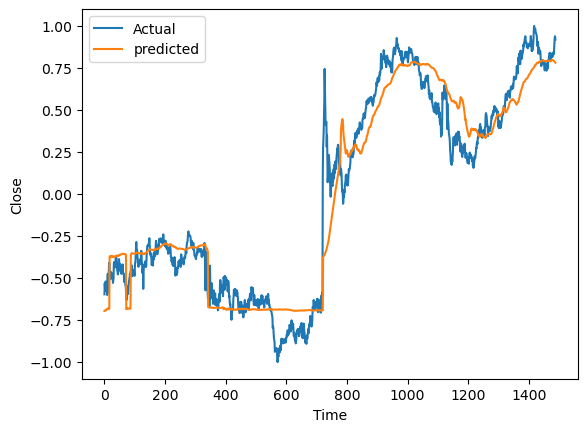

In [29]:
plt.plot(y_train,label="Actual")
plt.plot(predicted,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [30]:
train_prediction=predicted.flatten()
dummies=np.zeros((x_train.shape[0],lookback+1))
dummies[:,0]=train_prediction
dummies=scalar.inverse_transform(dummies)
train_prediction=dc(dummies[:,0])
train_prediction

array([174.71981863, 174.71857823, 174.7271085 , ..., 178.95097016,
       178.94441307, 178.93541311])

In [31]:
dummies=np.zeros((x_train.shape[0],lookback+1))
dummies[:,0]=y_train.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_train=dc(dummies[:,0])
new_y_train

array([175.00219719, 175.18989556, 175.08999632, ..., 179.36999507,
       179.3849945 , 179.3300019 ])

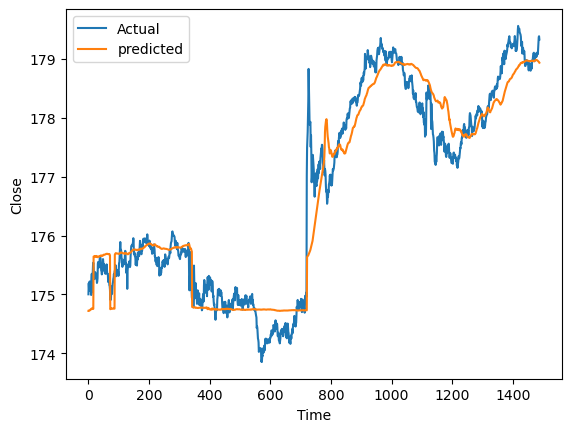

In [32]:
plt.plot(new_y_train,label="Actual")
plt.plot(train_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [33]:
test_prediction=model(x_test.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_test.shape[0],lookback+1))
dummies[:,0]=test_prediction.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction

array([177.48906358, 177.49285518, 177.50145109, 177.51503514,
       177.52288875, 177.53551673, 177.54958068, 177.56118363,
       177.57900025, 177.58653704, 177.59924945, 177.61266777,
       177.60082214, 177.59322974, 177.58636791, 177.5938729 ,
       177.60968794, 177.6243192 , 177.64190436, 177.66407709,
       177.68068221, 177.6990754 , 177.70598077, 177.71396337,
       177.72769766, 177.73754621, 177.74986316, 177.76460623,
       177.7758093 , 177.78002214, 177.78285658, 177.7822527 ,
       177.78451957, 177.78411943, 177.78407657, 177.78765501,
       177.7814797 , 177.78075789, 177.78298854, 177.78295062,
       177.78581958, 177.79107657, 177.7926082 , 177.79292697,
       177.79899183, 177.79916809, 177.80147909, 177.80673362,
       177.80750288, 177.8060204 , 177.80410189, 177.8005732 ,
       177.79432595, 177.7873228 , 177.78863582, 177.78432809,
       177.7835357 , 177.7705415 , 177.76812583, 177.77379896,
       177.7809271 , 177.79831041, 177.82185695, 177.84

In [34]:
dummies=np.zeros((x_test.shape[0],lookback+1))
dummies[:,0]=y_test.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test

array([177.36000061, 177.36000061, 177.43499753, 177.52960203,
       177.59930421, 177.63999937, 177.61999514, 177.60000612,
       177.6049957 , 177.67750553, 177.66999816, 177.63499449,
       177.63999937, 177.67999271, 177.7400055 , 177.72479248,
       177.72999573, 177.699707  , 177.69000248, 177.71989439,
       177.67999271, 177.60029599, 177.63499449, 177.63000491,
       177.53500366, 177.55000301, 177.57499692, 177.57000734,
       177.60000612, 177.65499881, 177.58999635, 177.58999635,
       177.64999392, 177.69000248, 177.71589658, 177.72500607,
       177.58999635, 177.6049957 , 177.60000612, 177.58999635,
       177.5800018 , 177.5800018 , 177.58999635, 177.61000059,
       177.63000491, 177.57000734, 177.52999878, 177.43499753,
       177.36990358, 177.31509401, 177.36999512, 177.36999512,
       177.3500061 , 177.33999633, 177.41000367, 177.33999633,
       177.50999454, 177.49999999, 177.52499389, 177.52000431,
       177.52999878, 177.55000301, 177.48500064, 177.49

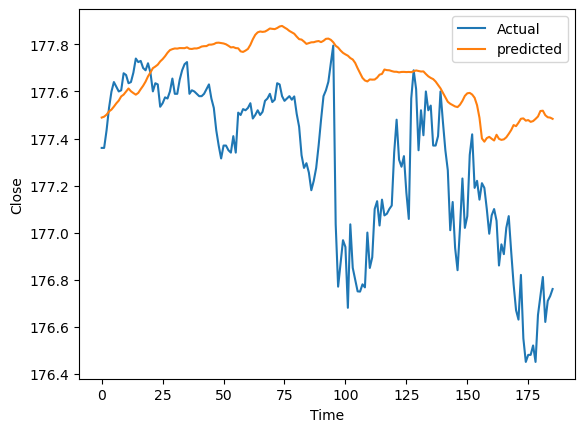

In [35]:
plt.plot(new_y_test,label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [36]:
shifted_df=prepareforlstm(data1,lookback)
shifted_df=pd.DataFrame(shifted_df)
shifted_df
scalar=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)
shifted_df_as_np
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape
x_tr=torch.tensor(x.reshape((-1,lookback,1))).float()
y_tr=torch.tensor(y.reshape((-1,1))).float()
test_prediction=model(x_tr.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=test_prediction.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=y_tr.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test
plt.plot(new_y_test,label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()
test_prediction

ValueError: Found array with 0 sample(s) (shape=(0, 61)) while a minimum of 1 is required by MinMaxScaler.

In [38]:
shifted_df2=pd.DataFrame(shifted_df.loc[lookback,"close(t-1)":]).T
shifted_df2

KeyError: 60

In [ ]:
data1=pd.concat([train,pd.DataFrame({"close":[0.0]*30})],ignore_index=True,axis=0)
data1

,close
0,173.872803
1,173.660004
2,174.179993
3,174.339996
4,174.272903
...,...
1945,0.000000
1946,0.000000
1947,0.000000
1948,0.000000


In [ ]:
shifted_df=prepareforlstm(data,lookback)
shifted_df=pd.DataFrame(shifted_df)
df1=pd.DataFrame(scalar.fit_transform(shifted_df))


In [ ]:
data1.loc[:,"close":]
pd.DataFrame(scalar.fit_transform(data1)).loc[len(data1)-37:len(data1)-31,:]


,0
1913,0.967587
1914,0.968478
1915,0.969382
1916,0.967253
1917,0.968249
1918,0.968478
1919,0.968813


In [ ]:

df1=pd.DataFrame(scalar.fit_transform(data),columns=["close"])


In [ ]:
df1

,close
0,-0.927865
1,-1.000000
2,-0.823732
3,-0.769494
4,-0.792237
...,...
1945,-0.305083
1946,-0.271188
1947,-0.335595
1948,-0.366103


In [ ]:
train=df1.loc[:len(df1)-31,:]
test=df1.loc[len(df1)-30:,:]

In [ ]:
test=test.reset_index()

In [ ]:
test

,index,close
0,1920,0.030507
1,1921,0.043051
2,1922,-0.077965
3,1923,-0.145766
4,1924,-0.169290
5,1925,-0.159323
6,1926,-0.183049
7,1927,-0.223730
8,1928,-0.253694
9,1929,-0.250850


In [ ]:
data1=df1.loc[len(df1)-37:len(df1)-31,:]
df1.loc[len(df1)-30,:]

close    0.030507
Name: 1920, dtype: float64

In [ ]:
data1=pd.concat([data1,pd.DataFrame({"close":[0.0]})],ignore_index=True,axis=0)

In [ ]:
data1

,close
0,0.013557
1,0.040676
2,0.068168
3,0.003388
4,0.033694
5,0.040676
6,0.050845
7,0.000000


In [ ]:
np.array(data1)

array([[0.01355706],
       [0.04067635],
       [0.06816806],
       [0.00338797],
       [0.03369351],
       [0.04067635],
       [0.05084544],
       [0.        ]])

In [ ]:
shifted_df=prepareforlstm(data1,lookback)
shifted_df=pd.DataFrame(shifted_df)
shifted_df


,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
7,0.0,0.050845,0.040676,0.033694,0.003388,0.068168,0.040676,0.013557


In [ ]:
data1

,close
0,0.013557
1,0.040676
2,0.068168
3,0.003388
4,0.033694
5,0.040676
6,0.050845
7,0.000000


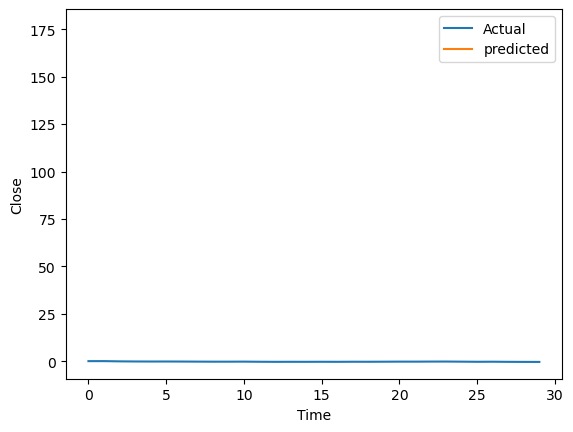

(0.048500404,
 close    176.699997
 Name: 1920, dtype: float64)

In [ ]:

shifted_df_as_np=np.array(shifted_df)
shifted_df_as_np
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape
x_tr=torch.tensor(x.reshape((-1,lookback,1))).float()
y_tr=torch.tensor(y.reshape((-1,1))).float()
test_prediction2=model(x_tr.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=test_prediction2.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=y_tr.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test
plt.plot(test.loc[0:,"close"],label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()
test_prediction2[0],data.loc[len(data)-30,:]

In [ ]:
shifted_df_as_np

array([[0.        , 0.05084544, 0.04067635, 0.03369351, 0.00338797,
        0.06816806, 0.04067635, 0.01355706]])

In [ ]:
a=pd.DataFrame(shifted_df.loc[8,:]).T

KeyError: 8

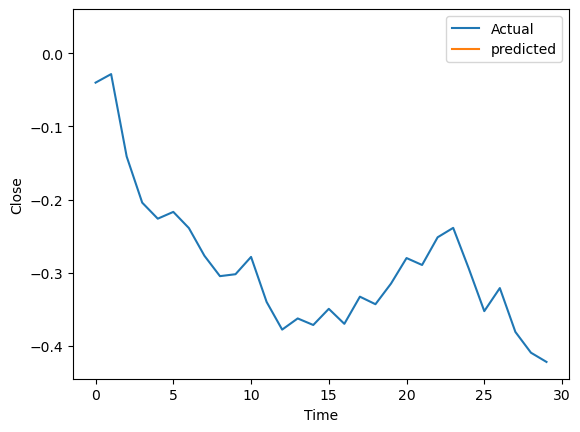

array([0.03745136])

In [ ]:
shifted_df=prepareforlstm(data1,lookback)
a=pd.DataFrame(shifted_df.loc[7,:]).T
shifted_df=pd.DataFrame(a)
shifted_df
scalar=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np=scalar.fit_transform(shifted_df)
shifted_df_as_np
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape
x_tr=torch.tensor(x.reshape((-1,lookback,1))).float()
y_tr=torch.tensor(y.reshape((-1,1))).float()
test_prediction=model(x_tr.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=test_prediction.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=y_tr.flatten()
dummies=scalar.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test
plt.plot(test.loc[:,"close"],label="Actual")
plt.plot(test_prediction,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()
test_prediction

In [43]:

lookback=60
df1=pd.DataFrame(scalar.fit_transform(data),columns=["close"])
data1=df1.loc[len(df1)-30-lookback:len(df1)-31,:]
shifted_df=prepareforlstm(data1,lookback)
data1=pd.concat([data1,pd.DataFrame({"close":[0.0]})],ignore_index=True,axis=0)
test_pred=[]
test_scale_pred=[]
lookback=60
shifted_df_as_np=np.array(shifted_df)
shifted_df_as_np
x=shifted_df_as_np[:,1:]
y=shifted_df_as_np[:,0]
x.shape,y.shape
x_tr=torch.tensor(x.reshape((-1,lookback,1))).float()
y_tr=torch.tensor(y.reshape((-1,1))).float()
test_prediction2=model(x_tr.to(device)).detach().cpu().numpy().flatten()
dummies=np.zeros((x_tr.shape[0],lookback+1))
dummies[:,0]=test_prediction2.flatten()
dummies=scalar.inverse_transform(dummies)
test_prediction=dc(dummies[:,0])
test_prediction
for i in range(30):
    shifted_df=prepareforlstm(data1,lookback)
    shifted_df=pd.DataFrame(shifted_df)
    shifted_df_as_np=np.array(shifted_df)
    x=shifted_df_as_np[:,1:]
    y=shifted_df_as_np[:,0]
    x.shape,y.shape
    x_tr=torch.tensor(x.reshape((-1,lookback,1))).float()
    y_tr=torch.tensor(y.reshape((-1,1))).float()
    test_prediction2=model(x_tr.to(device)).detach().cpu().numpy().flatten()
    test_scale_pred.append(test_prediction2[0])
    dummies=np.zeros((x_tr.shape[0],lookback+1))
    dummies[:,0]=test_prediction2.flatten()
    dummies=scalar.inverse_transform(dummies)
    test_prediction=dc(dummies[:,0])
    test_pred.append(test_prediction[0])
    data1.loc[lookback,"close"]=test_prediction2[0]
    data1=data1.drop(0,axis=0)
    data1=pd.concat([data1,pd.DataFrame({"close":[0.0]})],ignore_index=True,axis=0)
    


ValueError: Found array with 0 sample(s) (shape=(0, 61)) while a minimum of 1 is required.

In [ ]:
data1

,close
0,0.347646
1,0.352517
2,0.357081
3,0.361369
4,0.365408
5,0.369222
6,0.372831
7,0.000000


In [ ]:
test_pred

[176.82828086981408,
 176.86211537118606,
 176.8994916871552,
 176.96335767460778,
 177.01062295566908,
 177.06310609644197,
 177.11486040727368,
 177.1625821521534,
 177.21136751399672,
 177.25799487104678,
 177.300012049031,
 177.3403904586071,
 177.37751445347476,
 177.41178475822653,
 177.44352464278927,
 177.4724685985475,
 177.4990068000825,
 177.5235212457169,
 177.54600182502327,
 177.56674771873622,
 177.5859187595256,
 177.60366695546963,
 177.62017244800973,
 177.63555647435805,
 177.64992321587533,
 177.66338863476813,
 177.676038274044,
 177.68795301712225,
 177.69920407657855,
 177.7098515874768]

In [ ]:
y_score=data.loc[len(data)-30:,:]
y_score.reset_index(inplace=True)

In [ ]:
y_score

,index,close
0,1920,176.699997
1,1921,176.737000
2,1922,176.380005
3,1923,176.179993
4,1924,176.110596
5,1925,176.139999
6,1926,176.070007
7,1927,175.949997
8,1928,175.861603
9,1929,175.869995


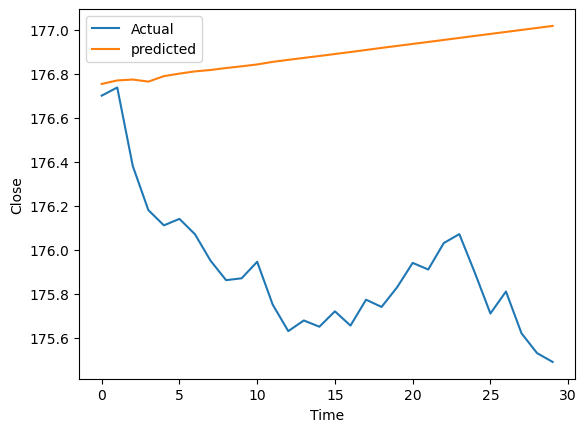

array([177.01678232])

In [ ]:
plt.plot(y_score.loc[:,"close"],label="Actual")
plt.plot(test_pred,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()
test_prediction